In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import gensim.downloader as api

# --------------------
# 1. Data Loading & Preprocessing
# --------------------
# Load dataset
df = pd.read_csv('modified_dataset_for_ML.csv')

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pre-trained Word2Vec
w2v_model = api.load("word2vec-google-news-300")

MAX_LEN = 300
EMBEDDING_DIM = 300

def get_word_vector(word):
    try:
        return w2v_model[word]
    except KeyError:
        return np.zeros(EMBEDDING_DIM)


def review_to_tensor(review):
    tokens = review.split()[:MAX_LEN]
    vecs = [get_word_vector(w) for w in tokens]
    if len(vecs) < MAX_LEN:
        vecs += [np.zeros(EMBEDDING_DIM)] * (MAX_LEN - len(vecs))
    return np.array(vecs, dtype=np.float32)


# Dataset Class
class IMDBDataset(Dataset):
    def __init__(self, dataframe):
        self.reviews = dataframe['processed_review'].values
        self.labels = dataframe['sentiment'].values

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review_tensor = review_to_tensor(self.reviews[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return review_tensor, label


# Create DataLoaders
batch_size = 64
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_loader = DataLoader(IMDBDataset(train_df), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(IMDBDataset(test_df),  batch_size=batch_size, shuffle=False)

# --------------------
# 2. Hybrid CNN-LSTM Model
# --------------------
class HybridCNNLSTM(nn.Module):
    def __init__(self, emb_dim, n_filters, filter_sizes, lstm_hidden, output_dim, dropout=0.5):
        super(HybridCNNLSTM, self).__init__()
        # Multi-kernel CNN layers
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, emb_dim), padding=(fs//2, 0))
            for fs in filter_sizes
        ])
        self.pool    = nn.MaxPool1d(kernel_size=2)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # 2-layer Bi-directional LSTM
        self.lstm = nn.LSTM(
            input_size = n_filters * len(filter_sizes),
            hidden_size= lstm_hidden,
            num_layers = 2,
            batch_first= True,
            bidirectional=True,
            dropout=dropout
        )

        # Final fully connected layer
        self.fc = nn.Linear(lstm_hidden * 2, output_dim)

    def forward(self, x):
        # x: [batch, seq_len, emb_dim]
        x = x.unsqueeze(1)  # [batch, 1, seq_len, emb_dim]
        conv_outs = []
        for conv in self.convs:
            c = self.relu(conv(x)).squeeze(3)  # [batch, n_filters, seq_len]
            c = self.pool(c)                   # [batch, n_filters, seq_len//2]
            conv_outs.append(c)
        # Concatenate along filter dimension
        x_cat = torch.cat(conv_outs, dim=1)  # [batch, n_filters*len, seq_len//2]
        x_cat = x_cat.permute(0, 2, 1)        # [batch, seq_len//2, n_filters*len]

        # LSTM
        lstm_out, _ = self.lstm(x_cat)       # [batch, seq_len//2, lstm_hidden*2]
        last = lstm_out[:, -1, :]            # [batch, lstm_hidden*2]
        out  = self.dropout(last)
        return torch.sigmoid(self.fc(out))   # [batch, 1]

# Instantiate model
model = HybridCNNLSTM(
    emb_dim=EMBEDDING_DIM,
    n_filters=100,
    filter_sizes=[3, 4, 5],
    lstm_hidden=128,
    output_dim=1,
    dropout=0.5
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20
best_test_acc = 0.0
best_model_path = "best_hybrid_model.pt"

# --------------------
# 3. Training Loop
# --------------------
print("Starting training...")
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Accuracy function
    def calculate_accuracy(loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for Xb, yb in loader:
                Xb = Xb.to(device)
                yb = yb.to(device).unsqueeze(1)
                preds = model(Xb)
                predicted = (preds > 0.5).float()
                correct += (predicted == yb).sum().item()
                total += yb.size(0)
        return correct / total

    train_acc = calculate_accuracy(train_loader)
    test_acc  = calculate_accuracy(test_loader)

    print(f"Epoch {epoch} Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), best_model_path)

print(f"Training completed. Best Test Accuracy: {best_test_acc*100:.2f}%")
print(f"Best model saved as {best_model_path}")

# --------------------
# 4. Evaluate Best Model
# --------------------
model.load_state_dict(torch.load(best_model_path))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        preds  = (model(inputs) > 0.5).long().cpu().numpy().flatten()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.numpy().tolist())

print(classification_report(y_true, y_pred))


Device: cuda
Starting training...


Epoch 1/20: 100%|██████████| 625/625 [00:45<00:00, 13.76it/s]


Epoch 1 Loss: 0.6927, Train Acc: 0.5170, Test Acc: 0.5098


Epoch 2/20: 100%|██████████| 625/625 [00:45<00:00, 13.62it/s]


Epoch 2 Loss: 0.6845, Train Acc: 0.6544, Test Acc: 0.6500


Epoch 3/20: 100%|██████████| 625/625 [00:47<00:00, 13.20it/s]


Epoch 3 Loss: 0.6206, Train Acc: 0.8468, Test Acc: 0.8406


Epoch 4/20: 100%|██████████| 625/625 [00:46<00:00, 13.31it/s]


Epoch 4 Loss: 0.3783, Train Acc: 0.8828, Test Acc: 0.8672


Epoch 5/20: 100%|██████████| 625/625 [00:48<00:00, 12.94it/s]


Epoch 5 Loss: 0.2979, Train Acc: 0.9075, Test Acc: 0.8770


Epoch 6/20: 100%|██████████| 625/625 [00:47<00:00, 13.07it/s]


Epoch 6 Loss: 0.2524, Train Acc: 0.9364, Test Acc: 0.8830


Epoch 7/20: 100%|██████████| 625/625 [00:48<00:00, 12.96it/s]


Epoch 7 Loss: 0.2011, Train Acc: 0.9584, Test Acc: 0.8821


Epoch 8/20: 100%|██████████| 625/625 [01:05<00:00,  9.50it/s]


Epoch 8 Loss: 0.1418, Train Acc: 0.9717, Test Acc: 0.8718


Epoch 9/20: 100%|██████████| 625/625 [00:54<00:00, 11.41it/s]


Epoch 9 Loss: 0.1064, Train Acc: 0.9851, Test Acc: 0.8792


Epoch 10/20: 100%|██████████| 625/625 [00:49<00:00, 12.56it/s]


Epoch 10 Loss: 0.0818, Train Acc: 0.9892, Test Acc: 0.8789


Epoch 11/20: 100%|██████████| 625/625 [00:47<00:00, 13.27it/s]


Epoch 11 Loss: 0.0635, Train Acc: 0.9870, Test Acc: 0.8775


Epoch 12/20: 100%|██████████| 625/625 [00:47<00:00, 13.08it/s]


Epoch 12 Loss: 0.0542, Train Acc: 0.9883, Test Acc: 0.8725


Epoch 13/20: 100%|██████████| 625/625 [00:46<00:00, 13.32it/s]


Epoch 13 Loss: 0.0485, Train Acc: 0.9942, Test Acc: 0.8801


Epoch 14/20: 100%|██████████| 625/625 [00:47<00:00, 13.04it/s]


Epoch 14 Loss: 0.0451, Train Acc: 0.9914, Test Acc: 0.8751


Epoch 15/20: 100%|██████████| 625/625 [00:47<00:00, 13.09it/s]


Epoch 15 Loss: 0.0431, Train Acc: 0.9948, Test Acc: 0.8802


Epoch 16/20: 100%|██████████| 625/625 [00:47<00:00, 13.07it/s]


Epoch 16 Loss: 0.0412, Train Acc: 0.9937, Test Acc: 0.8800


Epoch 17/20: 100%|██████████| 625/625 [00:47<00:00, 13.13it/s]


Epoch 17 Loss: 0.0414, Train Acc: 0.9901, Test Acc: 0.8783


Epoch 18/20: 100%|██████████| 625/625 [00:46<00:00, 13.41it/s]


Epoch 18 Loss: 0.0384, Train Acc: 0.9951, Test Acc: 0.8748


Epoch 19/20: 100%|██████████| 625/625 [00:48<00:00, 12.78it/s]


Epoch 19 Loss: 0.0300, Train Acc: 0.9950, Test Acc: 0.8806


Epoch 20/20: 100%|██████████| 625/625 [00:49<00:00, 12.72it/s]


Epoch 20 Loss: 0.0329, Train Acc: 0.9939, Test Acc: 0.8745
Training completed. Best Test Accuracy: 88.30%
Best model saved as best_hybrid_model.pt
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.88      4961
         1.0       0.89      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



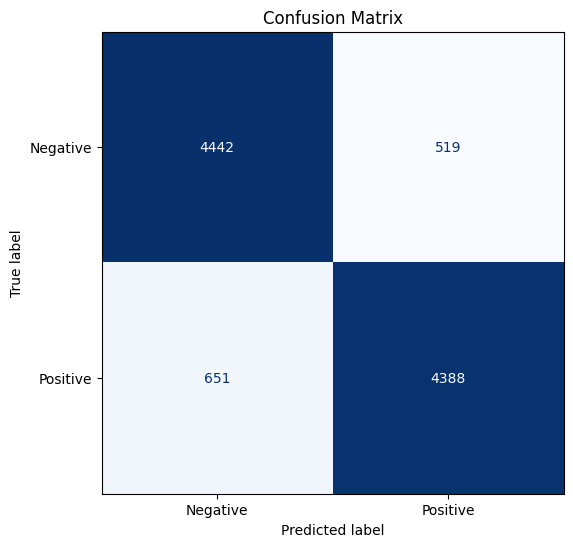

Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88      4961
    Positive       0.89      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



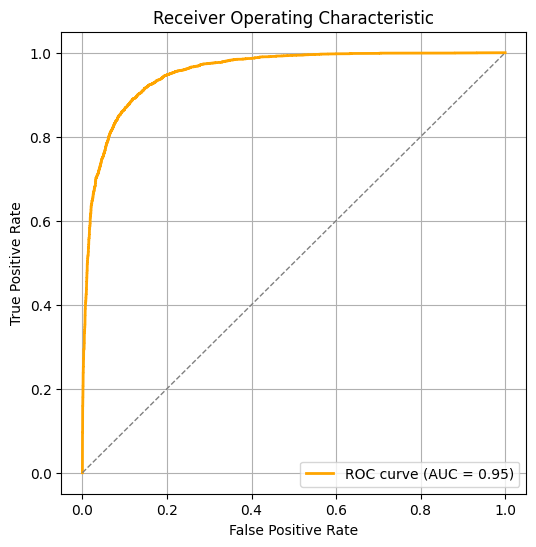

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

# Load Best Model for Evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Collect predictions
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        probs = outputs.cpu().numpy().flatten()
        predicted = (outputs > 0.5).float().cpu().numpy().flatten()

        all_preds.extend(predicted)
        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(probs)

# Confusion Matrix (Blue-White)
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()
